# Práctica 4: Sensado y análisis de datos Fisiológicos
## Identificación de estres en presentaciones

### Librerías

In [81]:
import sys
import os
import cv2
import unicodedata
from pydub import AudioSegment
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import pyhrv.time_domain as td
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Acerca del conjunto de datos

Los datos fueron recolectados mediante el dispositivo Polar h10, el cual es un sensor de frecuencia cardíaca altamente preciso y conectado, considerado el estándar de oro en la medición de la frecuencia cardíaca sin cables. Los participantes se colocaron el sensor y fueron sensados mientras exponian una presentación de proyecto. La dinamica estaba diseñada para que el participante en momentos distribuidos de forma aleatoria presentara estres ante situaciones fuera de su control. Como lo es las interrupciones a mitad de presentación, preguntas muy especificas, comentarios de caracter muy critico, etc. 

Los datos fueron recolectados con el uso de la aplicación Elite HRV, la cual se conecta al dispositivo con el objetivo de calcular los intervalos RR de la frecuencia cardíaca para posteriormente entregarsela al recolector en un archivo de texto.

<img style="margin-left:35%" width="30%" src="./img/intervalos rr.png" alt="Imagen representativa de los intervalos RR">

### Cargar los datos

En este apartado, cargamos nuestras bases de datos, cabe mencionar que con fines de interpretación, se realizo toma de audio y video, con el objetivo de identificar de forma empirica los momentos de estres que pueden presentar los participantes.

#### Datos Fisiológicos

In [2]:
path = './Fisiologico/'
list_dir = os.listdir(path=path)
fisiological_data = {}
for dir in list_dir:
    if dir.startswith("Videos") or dir.startswith("Audios"):
        continue
    file = dir.upper()
    fisiological_data[file] = pd.read_csv(path + dir +"/"+ file + ".txt", header=None, names=["intervalRR"])

#### Datos Audios

In [3]:
def quitar_acentos(palabra):
    palabra_normalizada = unicodedata.normalize('NFD', palabra)
    palabra_sin_acentos = ''.join(c for c in palabra_normalizada if unicodedata.category(c) != 'Mn')
    return palabra_sin_acentos

path = './Fisiologico/Audios/'
list_dir = os.listdir(path=path)
audio_data = {}
for dir in list_dir:
    file = quitar_acentos(dir[:-4])
    audio_data[file] = audio = AudioSegment.from_file(path + dir)
    

#### Datos Videos

In [4]:
path = './Fisiologico/Videos/'
list_dir = os.listdir(path=path)
video_data = {}
for dir in list_dir:
    video_data[dir[:-4]] = cv2.VideoCapture(path + dir)

### Analisis Exploratorio y preprocesado de datos

En este apartado, se realiza un analisis exploratorio de los datos fisiológicos, con el objetivo de limpiarlos u empatarlos a nivel del tiempo de las otras modalidades de datos.

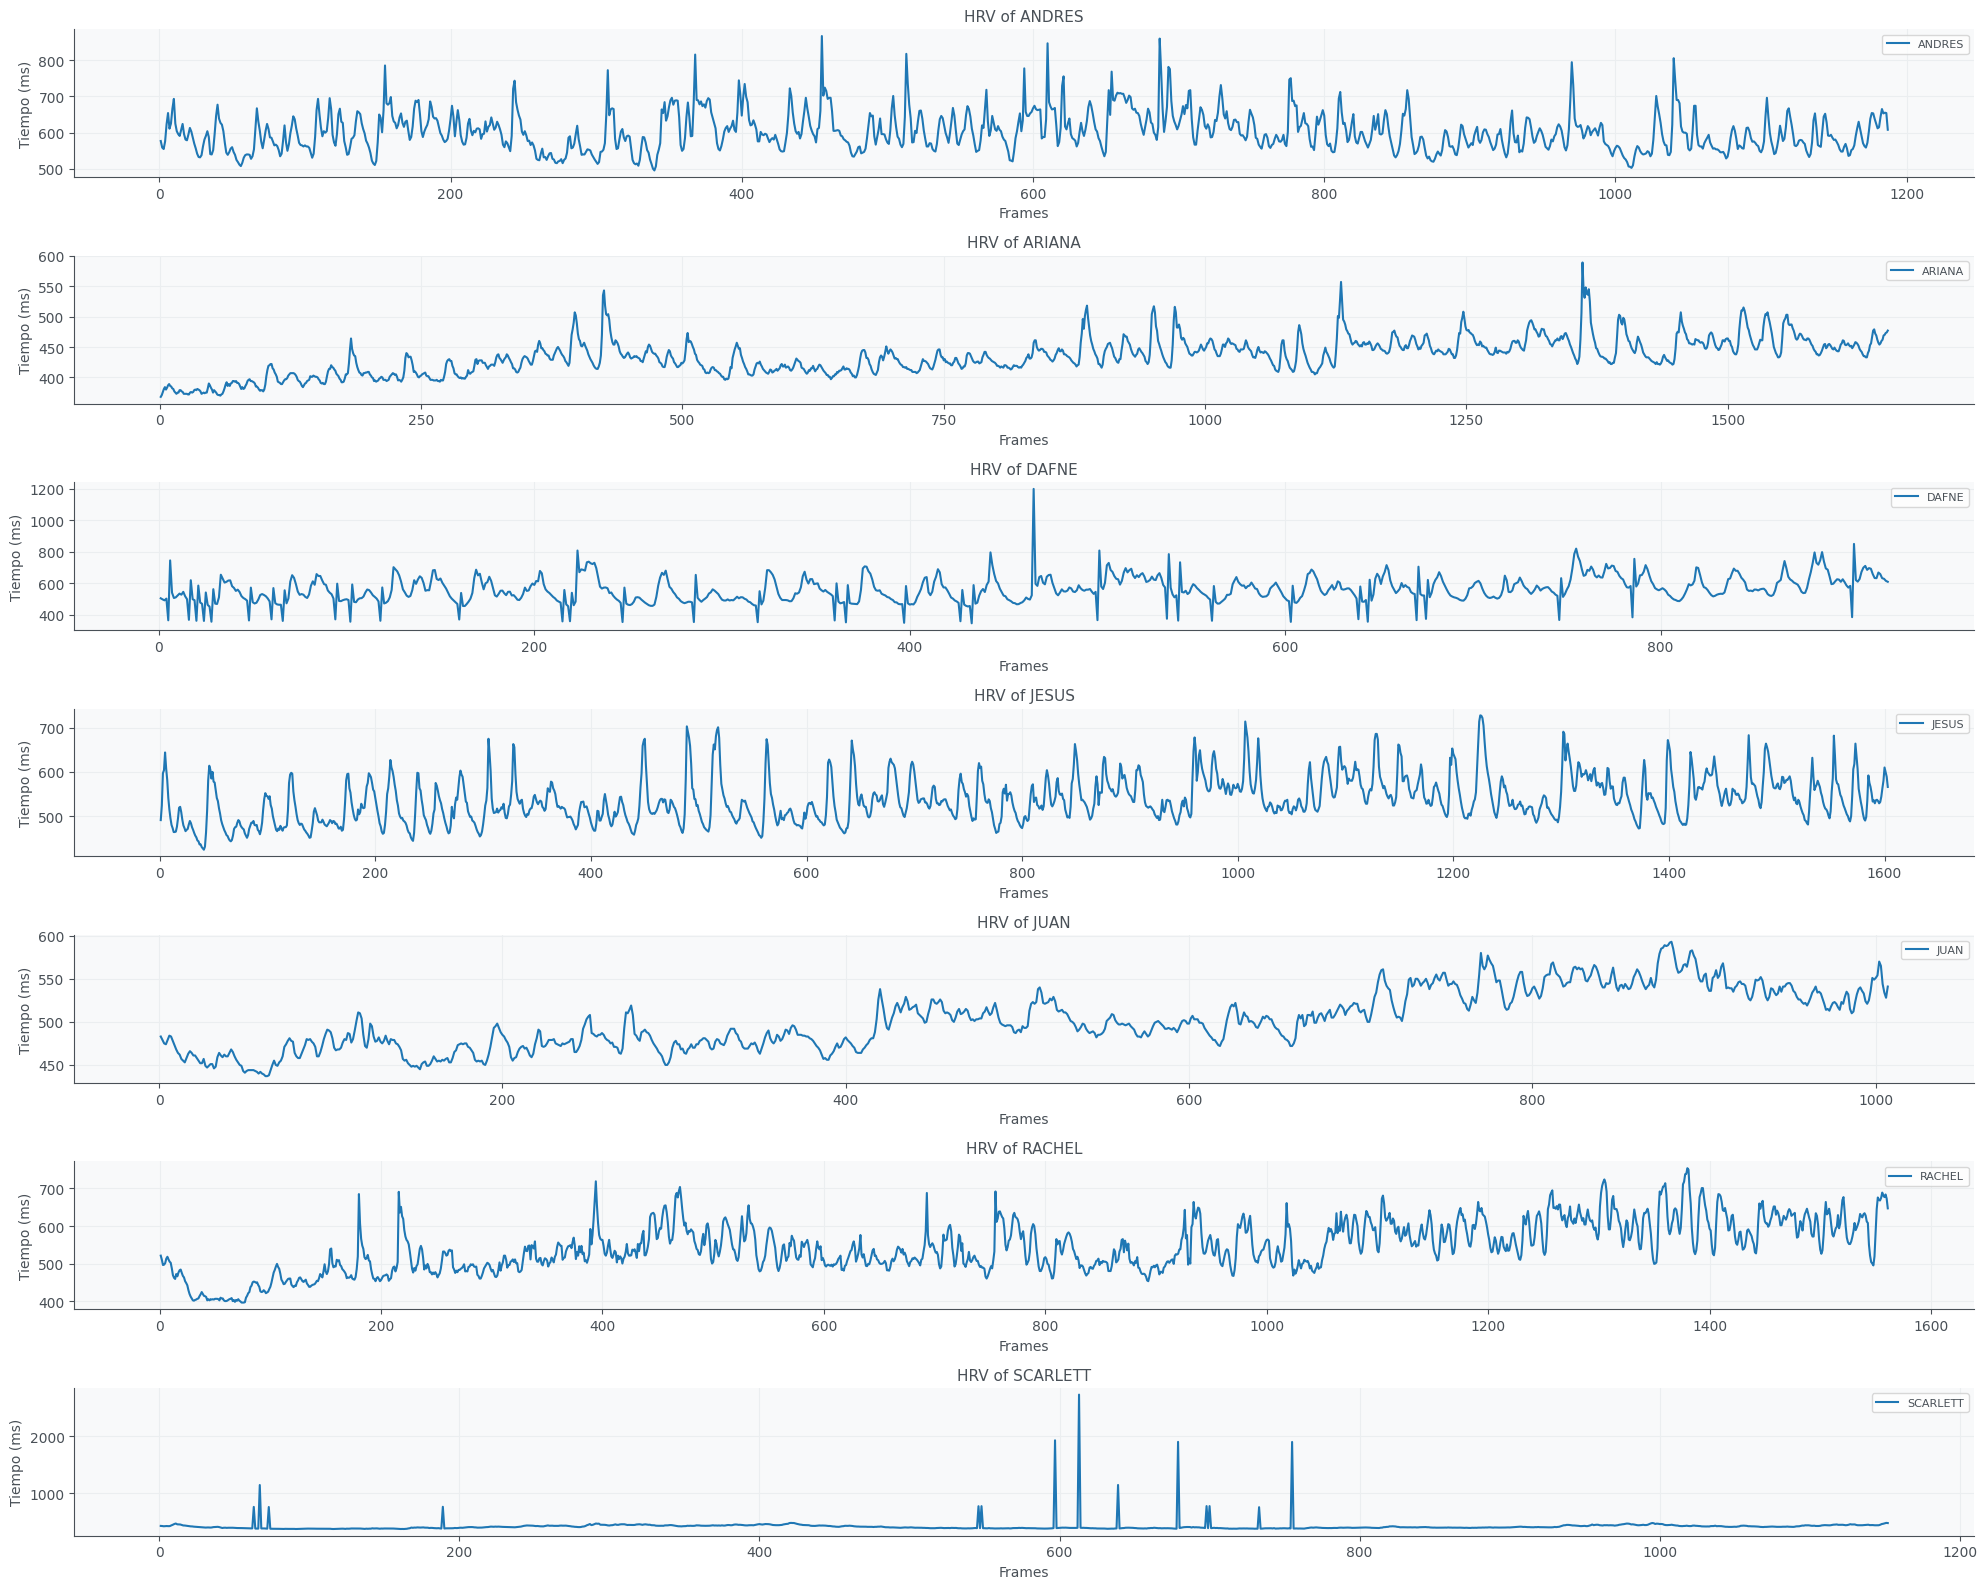

In [5]:
fig, axs = plt.subplots(nrows=len(fisiological_data), ncols=1, figsize=(20, 16))
for i, data in enumerate(fisiological_data):
    x_values = range(1, len(fisiological_data[data]) + 1)
    
    axs[i].plot(x_values, fisiological_data[data], label=data)
    axs[i].set_title('HRV of ' + data)
    axs[i].set_xlabel('Frames')
    axs[i].set_ylabel('Tiempo (ms)')
    axs[i].legend()

plt.tight_layout()
plt.show()


#### Analisis de perdida de datos

Los intervalos RR representan la distancia entre un pico R y otro en dominio del tiempo (ms), por lo que, siguiendo este razonamiento, se puede realizar la suma total de los intervalos capturados de cada sujeto, con el objetivo de conocer la duración a comparación de las demas modalidades de datos.

Para esto, se capturo el tiempo en milisegundos de cada modalidad y se transformo a formato timestamp y se crea un dataframe para analizar cada conjunto de datos recolectado en las diferentes modalidades y su duración en función del tiempo.

In [6]:
def obtener_duracion(video):
    fps = video.get(cv2.CAP_PROP_FPS)
    total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
    duracion_segundos = total_frames / fps
    duracion_milisegundos = duracion_segundos * 1000
    video.release()
    return duracion_milisegundos

In [7]:
def milisegundos_a_timestamp(milisegundos):
    # Convertir milisegundos a segundos
    segundos_totales = int(milisegundos // 1000)
    milisegundos_restantes = int(milisegundos % 1000)  # Convertir a entero para asegurar el formato correcto
    horas = int(segundos_totales // 3600)
    minutos = int((segundos_totales % 3600) // 60)
    segundos = int(segundos_totales % 60)
    # Formatear como HH:MM:SS.mmm donde 'mmm' son los milisegundos
    return f"{horas:02d}:{minutos:02d}:{segundos:02d}.{milisegundos_restantes:03d}"


In [8]:
# Lista para recopilar los datos
datos = []

# Suponiendo que 'fisiological_data', 'audio_data', y 'video_data' son tus datos de entrada
for data in fisiological_data:
    # HRV
    milisegundos_hrv = fisiological_data[data]["intervalRR"].sum()
    duracion_hrv = milisegundos_a_timestamp(milisegundos_hrv)
    datos.append({"Sujeto": data + " - HRV", "Milisegundos": milisegundos_hrv, "Duración": duracion_hrv})
    
    # Audio
    milisegundos_audio = len(audio_data[data])
    duracion_audio = milisegundos_a_timestamp(milisegundos_audio)
    datos.append({"Sujeto": data + " - Audio", "Milisegundos": milisegundos_audio, "Duración": duracion_audio})
    
    # Video
    milisegundos_video = obtener_duracion(video_data[data])
    duracion_video = milisegundos_a_timestamp(milisegundos_video)
    datos.append({"Sujeto": data + " - Video", "Milisegundos": milisegundos_video, "Duración": duracion_video})

# Crear el DataFrame
df = pd.DataFrame(datos)

# Mostrar el DataFrame
print(df)


              Sujeto  Milisegundos      Duración
0       ANDRES - HRV      715114.0  00:11:55.114
1     ANDRES - Audio      713472.0  00:11:53.472
2     ANDRES - Video      333333.0  00:05:33.333
3       ARIANA - HRV      718470.0  00:11:58.470
4     ARIANA - Audio      717472.0  00:11:57.472
5     ARIANA - Video      715915.2  00:11:55.915
6        DAFNE - HRV      517451.0  00:08:37.451
7      DAFNE - Audio      517600.0  00:08:37.600
8      DAFNE - Video      516415.9  00:08:36.415
9        JESUS - HRV      862743.0  00:14:22.743
10     JESUS - Audio      860576.0  00:14:20.576
11     JESUS - Video      460359.9  00:07:40.359
12        JUAN - HRV      505449.0  00:08:25.449
13      JUAN - Audio      503424.0  00:08:23.424
14      JUAN - Video      504804.3  00:08:24.804
15      RACHEL - HRV      850158.0  00:14:10.158
16    RACHEL - Audio      848640.0  00:14:08.640
17    RACHEL - Video      848848.0  00:14:08.848
18    SCARLETT - HRV      482244.0  00:08:02.244
19  SCARLETT - Audio

Como se observa en los resultados anteriores, los conjuntos de datos HRV parecen no tener perdida significativa. En el caso de os archivos de video, se reporto problemas de corte a la hora de recolectar los videos.

Con esto aclarado, podemos tomar nuestras señales HRV como una serie de tiempo. Por lo que en las siguientes celdas, se le agregara un Timestamp a los datos HRV.

In [9]:
for subject in fisiological_data:
    df = fisiological_data[subject]  # Para mejorar la legibilidad
    tiempoAcumulado = 0  # Reinicia para cada sujeto
    timestamps = []  # Lista para almacenar los timestamps calculados
    
    for index, row in df.iterrows():
        tiempoAcumulado += row["intervalRR"]
        timestamp = milisegundos_a_timestamp(tiempoAcumulado)
        timestamps.append(timestamp)
    
    df["timestamp"] = pd.to_datetime(timestamps, format='%H:%M:%S.%f')  # Asignar la lista de timestamps a la columna 'timestamp' del DataFrame

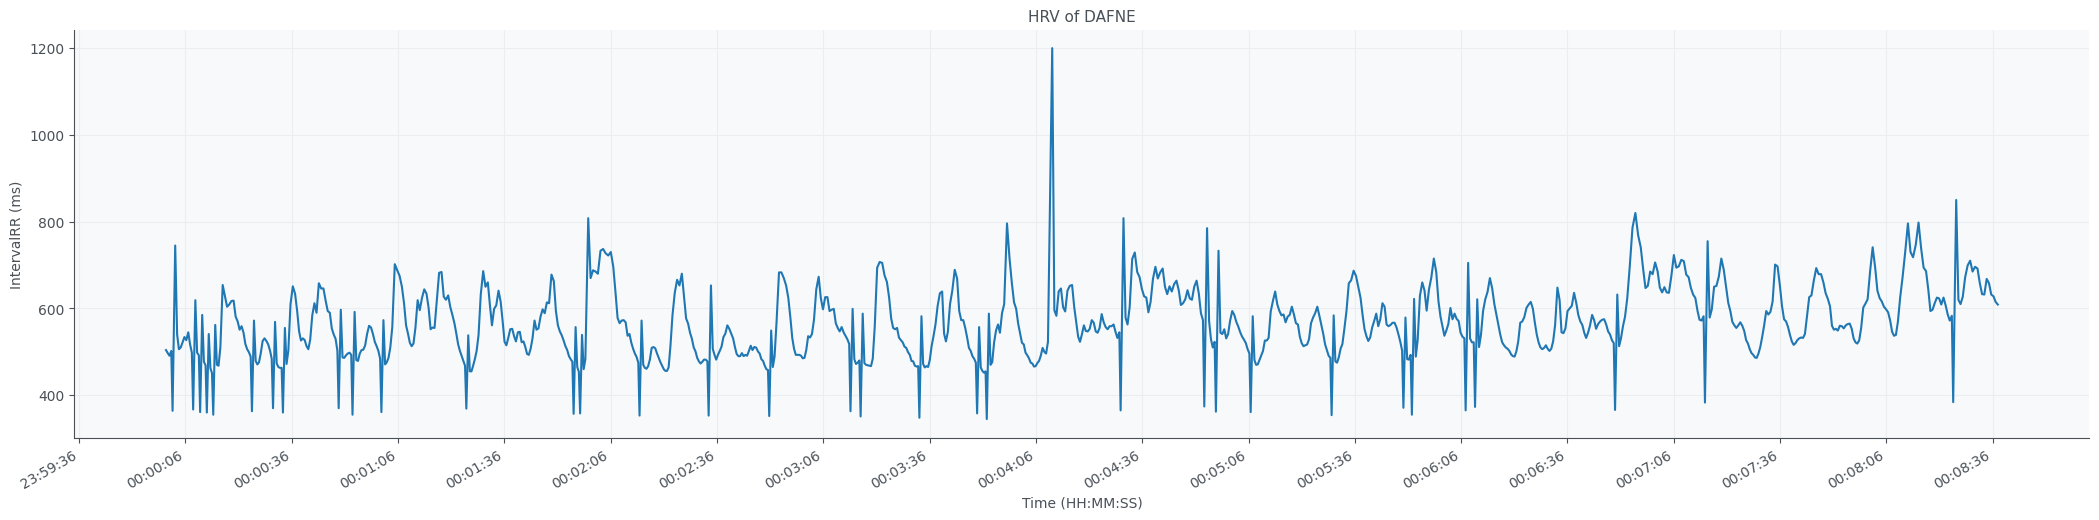

In [10]:
# Configurar el tamaño de la figura
plt.figure(figsize=(26, 6))

# Graficar los datos
plt.plot(fisiological_data["DAFNE"]["timestamp"], fisiological_data["DAFNE"]["intervalRR"])

# Establecer el título y las etiquetas de los ejes
plt.title('HRV of DAFNE')
plt.xlabel('Time (HH:MM:SS)')
plt.ylabel('IntervalRR (ms)')

# Formatear el eje X para mostrar solo la hora, minutos y segundos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Establecer la rotación de las etiquetas del eje X para mejorar la legibilidad
plt.gcf().autofmt_xdate()

# Opcional: Definir la frecuencia de los ticks en el eje X
plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=30))  # Ajusta el intervalo según necesites

plt.show()

### Segmentación de datos y extracción de caracteristicas

Para la segmentación, se decidio tomar una ventana de tiempo de 1 minuto aproximadamente de manera imparcial. Con esto en mente, la serie de tiempo dentro de la ventana sera procesada con el objetivo de extraer caracteristicas en el dominio del tiempo utilizando la libreria pyHRV.

In [20]:
caracteristicas_hrv = [
    "nni_counter", "nni_mean", "nni_min", "nni_max",
    "hr_mean", "hr_min", "hr_max", "hr_std",
    "nni_diff_mean", "nni_diff_min", "nni_diff_max",
    "sdnn", "sdnn_index", "sdann", "rmssd", "sdsd",
    "nn50", "pnn50", "nn20", "pnn20",
    "nni_histogram", "tinn_n", "tinn_m", "tinn", "tri_index"
]
def extraer_caracteristicas_hrv_tiempo(rr_intervals):
    # Asegúrate de que los intervalos RR estén en formato numpy array
    rr_intervals = np.array(rr_intervals)
    
    # Calcula características del dominio del tiempo
    time_domain_results = td.time_domain(nni=rr_intervals, plot=False)
    
    # Extraemos el diccionario de resultados
    resultados = pd.DataFrame([time_domain_results], columns=caracteristicas_hrv)  # [1] contiene el diccionario con los resultados
    
    return resultados

def obtener_intervalos_rr_por_ventana(df):
    # Agrupa el DataFrame por las columnas 'inicio_ventana' y 'fin_ventana'
    grupos = df.groupby(['inicio_ventana', 'fin_ventana'])
    
    # Para cada grupo, extrae los intervalos RR como una lista
    intervalos_rr_por_ventana = grupos.apply(lambda x: x['intervalRR'].tolist()).reset_index(name='intervalosRR')
    
    return intervalos_rr_por_ventana["intervalosRR"]

In [12]:
for subject in fisiological_data:
    df = fisiological_data[subject]
    # Ordenar el DataFrame por 'timestamp'
    df = df.sort_values('timestamp')

    # Lista para almacenar los resultados
    resultados = []
    # Inicializar las variables de inicio y fin de ventana
    inicio_ventana = df.iloc[0]['timestamp']
    fin_ventana = inicio_ventana + pd.Timedelta(minutes=1)

    # Iterar sobre las filas del DataFrame
    for index, row in df.iterrows():
        if row['timestamp'] <= fin_ventana:
            # La muestra actual pertenece a la ventana actual
            resultados.append(row.to_dict())
        else:
            # Actualizar las variables de inicio y fin para la nueva ventana
            inicio_ventana = row['timestamp']
            fin_ventana = inicio_ventana + pd.Timedelta(minutes=1)
            resultados.append(row.to_dict())

    # Convertir los resultados a DataFrame
    resultados_df = pd.DataFrame(resultados)

    # Agregar columnas de inicio y fin de ventana
    resultados_df['inicio_ventana'] = resultados_df['timestamp'].apply(lambda x: x.floor('T'))
    resultados_df['fin_ventana'] = resultados_df['inicio_ventana'] + pd.Timedelta(minutes=1) - pd.Timedelta(seconds=0.001)
    fisiological_data[subject] = resultados_df 

In [27]:
features_df = []
for subject in fisiological_data:
    df = fisiological_data[subject]
    intervalos_rr = obtener_intervalos_rr_por_ventana(df)
    feature_instance = []
    for interval in intervalos_rr:
        features = extraer_caracteristicas_hrv_tiempo(interval)
        # Agrega una nueva columna al DataFrame 'features' con el valor de 'subject'
        features['sujeto'] = subject
        # Asegúrate de que las columnas estén en el orden correcto, con 'sujeto' como la primera columna
        columnas = ['sujeto'] + [col for col in features.columns if col != 'sujeto']
        features = features[columnas]
        feature_instance.append(features)
    features_df.append(pd.concat(feature_instance))

features_df = pd.concat(features_df)


Se eliminaron las columans que presentan valores faltantes.

In [32]:
features_df.isna().sum()

sujeto            0
nni_counter       0
nni_mean          0
nni_min           0
nni_max           0
hr_mean           0
hr_min            0
hr_max            0
hr_std            0
nni_diff_mean     0
nni_diff_min      0
nni_diff_max      0
sdnn              0
sdnn_index       81
sdann            81
rmssd             0
sdsd              0
nn50              0
pnn50             0
nn20              0
pnn20             0
nni_histogram    81
tinn_n            0
tinn_m            0
tinn              0
tri_index         0
dtype: int64

In [34]:
features_df = features_df.drop(columns=['sdnn_index', 'sdann', 'nni_histogram'])
features_df.isna().sum()

sujeto           0
nni_counter      0
nni_mean         0
nni_min          0
nni_max          0
hr_mean          0
hr_min           0
hr_max           0
hr_std           0
nni_diff_mean    0
nni_diff_min     0
nni_diff_max     0
sdnn             0
rmssd            0
sdsd             0
nn50             0
pnn50            0
nn20             0
pnn20            0
tinn_n           0
tinn_m           0
tinn             0
tri_index        0
dtype: int64

Y se guardan las caracteristicas en un archivo .csv

In [39]:
features_df.to_csv("./caracteristicas.csv")

Despues de esto, de manera empirica considerando que los picos más altos en los  intervalos RR son los momentos de menor estres, se procedio a etiquetar el conjunto de datos con las etiquetas "Grave", "Moderado" y "Bajo", las cuales representas una escala de likert sencilla del estres. Para el etiquetado se tomaron en cuenta de manera prioritaria los valores de las siguientes caracteristicas:
- RMSSD.
- nni_max.
- hr_max.
- sdnn.

### Selección de características

En este apartado se realiza una selección de caracteristicas con el uso de información de ganancia. 

In [68]:
df = pd.read_csv("caracteristicas_con_etiquetas.csv")
df

,Unnamed: 0,sujeto,nni_counter,nni_mean,nni_min,nni_max,hr_mean,hr_min,hr_max,hr_std,...,sdsd,nn50,pnn50,nn20,pnn20,tinn_n,tinn_m,tinn,tri_index,label
0,0,ANDRES,103,579.757282,508.0,693.0,103.939770,86.580087,118.110236,6.781413,...,14.433457,3,2.941176,34,33.333333,500.0000,656.2500,156.2500,9.363636,Moderado
1,0,ANDRES,97,615.649485,511.0,785.0,98.051315,76.433121,117.416830,7.711505,...,22.017607,10,10.416667,41,42.708333,500.0000,703.1250,203.1250,12.125000,Bajo
2,0,ANDRES,104,579.192308,514.0,743.0,104.220229,80.753701,116.731518,7.955799,...,16.859895,3,2.912621,28,27.184466,507.8125,671.8750,164.0625,10.400000,Moderado
3,0,ANDRES,97,615.082474,496.0,815.0,98.628084,73.619632,120.967742,10.397382,...,29.907707,16,16.666667,37,38.541667,492.1875,726.5625,234.3750,12.125000,Bajo
4,0,ANDRES,99,610.626263,534.0,866.0,98.952213,69.284065,112.359551,7.964385,...,28.535509,5,5.102041,35,35.714286,523.4375,632.8125,109.3750,9.000000,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0,SCARLETT,137,438.087591,376.0,2725.0,150.189277,22.018349,159.574468,22.461910,...,389.536335,12,8.823529,12,8.823529,367.1875,406.2500,39.0625,2.795918,Bajo
77,0,SCARLETT,148,405.277027,377.0,1896.0,151.574778,31.645570,159.151194,12.196819,...,180.656868,4,2.721088,4,2.721088,367.1875,406.2500,39.0625,2.846154,Bajo
78,0,SCARLETT,142,422.542254,391.0,477.0,142.435833,125.786164,153.452685,7.869639,...,2.901752,0,0.000000,0,0.000000,375.0000,468.7500,93.7500,4.733333,Grave
79,0,SCARLETT,141,426.900709,406.0,456.0,140.673410,131.578947,147.783251,4.205322,...,2.336053,0,0.000000,0,0.000000,398.4375,453.1250,54.6875,4.700000,Grave


In [69]:
df = df.drop(['Unnamed: 0', 'sujeto'], axis=1)
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [70]:
Y

0     Moderado
1         Bajo
2     Moderado
3         Bajo
4         Bajo
        ...   
76        Bajo
77        Bajo
78       Grave
79       Grave
80       Grave
Name: label, Length: 81, dtype: object

In [71]:
from sklearn.preprocessing import OrdinalEncoder

# Crear el objeto OrdinalEncoder
encoder = OrdinalEncoder(categories=[['Bajo', 'Moderado', 'Grave']])

# Ajustar y transformar los datos asegurándose de que 'Y' sea un array 2D y luego aplanar el resultado
Y_2D = Y.values.reshape(-1, 1)  # Convertir Y a un array 2D
data_encoded_2D = encoder.fit_transform(Y_2D)  # Ajustar y transformar
y_encoded = data_encoded_2D.ravel()  # Aplanar el resultado a 1D

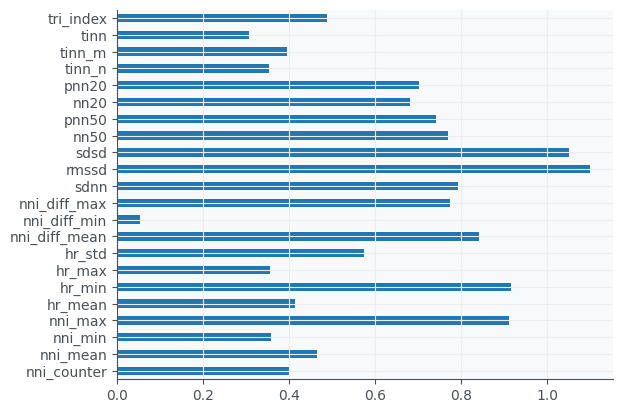

In [72]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

X_new = mutual_info_classif(X, Y)
feat_imp = pd.Series(X_new, df.columns[0:len(df.columns)-1])
feat_imp.plot(kind='barh')
plt.show()

In [73]:
# Filtrar las características con valores mayores al umbral
selected_features = df.columns[np.where(X_new > 0.4)].tolist()

# Mostrar las características seleccionadas
print("Características seleccionadas con valor mayor a", 0.13, ":", selected_features)
X = df[selected_features]

Características seleccionadas con valor mayor a 0.13 : ['nni_counter', 'nni_mean', 'nni_max', 'hr_mean', 'hr_min', 'hr_std', 'nni_diff_mean', 'nni_diff_max', 'sdnn', 'rmssd', 'sdsd', 'nn50', 'pnn50', 'nn20', 'pnn20', 'tri_index']


### Creación del modelo

En este apartado se mide el rendimiento de algunos algoritmos de machine learning con el objetivo de seleccionar el mejor algoritmo para la creación de un modelo que clasifique el estres.

##### Validación Cruzada

Estos fueron los algoritmos utilizados en esta ocasión:

In [74]:
names = [
    "Nearest Neighbors",
    "Decision Tree",
    "AdaBoost",
    "Naive Bayes",
    "Linear SVM",
]
modelos = [
    KNeighborsClassifier(n_neighbors=6),
    DecisionTreeClassifier(max_depth=10),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel='linear')
]

In [75]:
def validacion_cruzada(model, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracies = []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        X_test_np = X_test.values
        y_pred = model.predict(X_test_np)

        precision = precision_score(y_test, y_pred, average='weighted')
        precision_scores.append(precision)

        recall = recall_score(y_test, y_pred, average='weighted')
        recall_scores.append(recall)

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        accuracy = model.score(X_test, y_test)
        accuracies.append(accuracy)

    return np.mean(precision_scores), np.mean(recall_scores), np.mean(f1_scores), np.mean(accuracies)

resultados = []

for nombre, modelo in zip(names, modelos):
    precision, recall, f1, accuracy = validacion_cruzada(model=modelo, X=X, y=y_encoded)
    resultados.append({"nombre": nombre, "precision": precision, "recall": recall, "f1_score": f1, "accuracy": accuracy})

df_resultados = pd.DataFrame(resultados)

De acuerdo a los resultados obtenidos en la validación cruzada, podemos observar que hubo un empate entre los algoritmos AdaBoost (Meta-aprendizaje) y Decision Tree (ML tradicional).
Por lo que ambos seran entrenados para realizar una prueba de validación. 

In [76]:
df_resultados

,nombre,precision,recall,f1_score,accuracy
0,Nearest Neighbors,0.942083,0.9125,0.921372,0.9125
1,Decision Tree,1.000000,1.0000,1.000000,1.0000
2,AdaBoost,0.989583,0.9875,0.987500,0.9875
3,Naive Bayes,0.924375,0.9000,0.903542,0.9000
4,Linear SVM,0.949306,0.9375,0.939887,0.9375


#### Entrenar mejores modelos

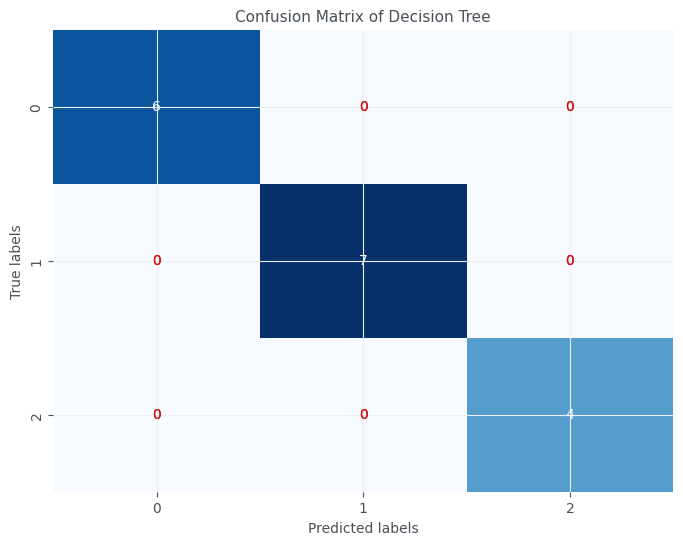

F1 Score: 1.0
Sensibilidad (Recall): 1.0
Especificidad por clase: [1.0, 1.0, 1.0]
Exactitud: 1.0


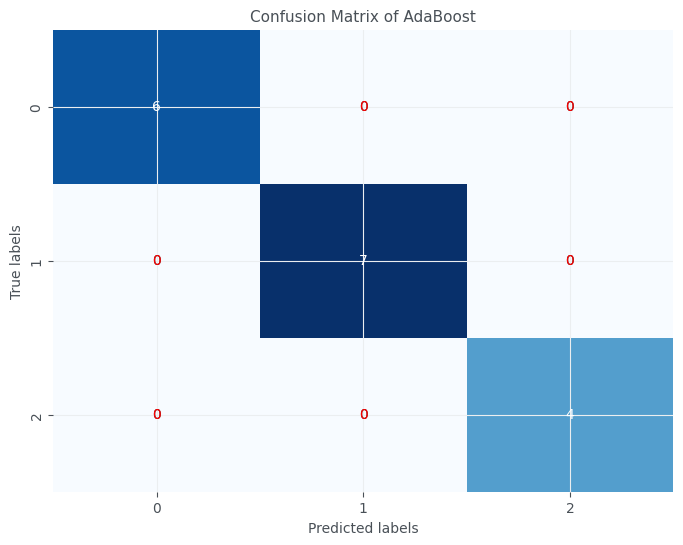

F1 Score: 1.0
Sensibilidad (Recall): 1.0
Especificidad por clase: [1.0, 1.0, 1.0]
Exactitud: 1.0


In [82]:
names = [
    "Decision Tree",
    "AdaBoost",
]
modelos = [
    DecisionTreeClassifier(max_depth=10),
    AdaBoostClassifier(),
]
# Primera división: Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Segunda división: Dividir el conjunto de entrenamiento para crear un conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

for nombre, modelo in zip(names, modelos):
    modelo.fit(X_train, y_train)
    # Obtener predicciones del modelo
    y_pred = modelo.predict(X_test)

    # Calcular la matriz de confusión multiclase
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calcular métricas adicionales
    f1 = f1_score(y_test, y_pred, average='weighted')
    sensibilidad = recall_score(y_test, y_pred, average='weighted')
    exactitud = accuracy_score(y_test, y_pred)

    # Calcular especificidad para cada clase
    especificidad = []
    for i in range(len(conf_matrix)):
        true_negative = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))
        total_negative = np.sum(np.delete(conf_matrix, i, 0))
        especificidad.append(true_negative / total_negative)

    # Visualizar la matriz de confusión con un mapa de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

    # Resaltar los valores donde el modelo se confundió
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
            if i != j:
                plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha="center", va="center", color="red")

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {nombre}')
    plt.show()

    # Imprimir métricas
    print("F1 Score:", f1)
    print("Sensibilidad (Recall):", sensibilidad)
    print("Especificidad por clase:", especificidad)
    print("Exactitud:", exactitud)

En los resultados anteriores podemos obsevar que para la fase de testing se obtuvo el mismo resultado en ambos algoritmos, sin embargo se tiene un tercer conjunto de datos de validación para ver cual es nuestro mejor candidato.

#### Validar nuestros mejores modelos

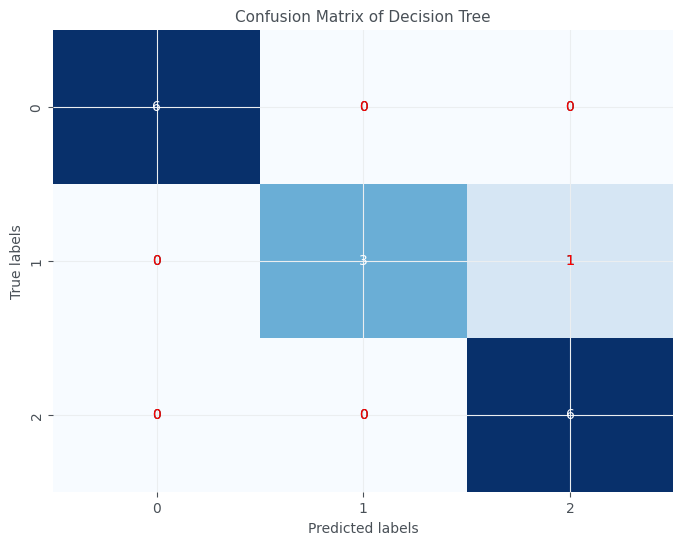

F1 Score: 0.9354395604395604
Sensibilidad (Recall): 0.9375
Especificidad por clase: [1.0, 1.0, 0.9]
Exactitud: 0.9375


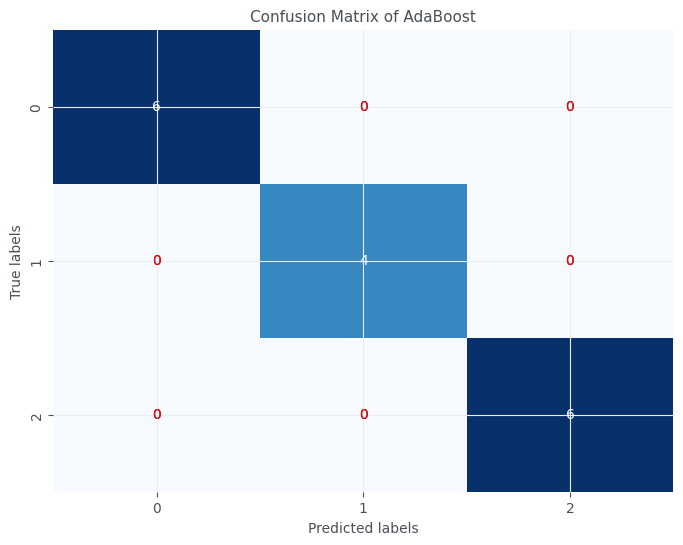

F1 Score: 1.0
Sensibilidad (Recall): 1.0
Especificidad por clase: [1.0, 1.0, 1.0]
Exactitud: 1.0


In [83]:
for nombre, modelo in zip(names, modelos):
    # Obtener predicciones del modelo
    y_pred = modelo.predict(X_val)

    # Calcular la matriz de confusión multiclase
    conf_matrix = confusion_matrix(y_val, y_pred)

    # Calcular métricas adicionales
    f1 = f1_score(y_val, y_pred, average='weighted')
    sensibilidad = recall_score(y_val, y_pred, average='weighted')
    exactitud = accuracy_score(y_val, y_pred)

    # Calcular especificidad para cada clase
    especificidad = []
    for i in range(len(conf_matrix)):
        true_negative = np.sum(np.delete(np.delete(conf_matrix, i, 0), i, 1))
        total_negative = np.sum(np.delete(conf_matrix, i, 0))
        especificidad.append(true_negative / total_negative)

    # Visualizar la matriz de confusión con un mapa de calor
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)

    # Resaltar los valores donde el modelo se confundió
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
            if i != j:
                plt.text(j + 0.5, i + 0.5, conf_matrix[i, j], ha="center", va="center", color="red")

    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {nombre}')
    plt.show()

    # Imprimir métricas
    print("F1 Score:", f1)
    print("Sensibilidad (Recall):", sensibilidad)
    print("Especificidad por clase:", especificidad)
    print("Exactitud:", exactitud)

En los resultados obtenidos en la prueba de validación, podemos observa que el algoritmo AdaBoost pudo clasifica de manera correcta todas las intancias en el conjunto de datos, por lo que este termina por ser el mejor modelo, sin embargo, no se descartan los resultados del algoritmo Decision Tree que es igual de bueno. Sin embargo presento un error tipo 2 en una de las clases.

### Conclusiones

Las señales fisiológicas pueden brindarnos un vistazo más exacto de los comportamientos de un cuerpo biológico que otras modalidades no pueden estimar del todo. Sin embargo, la representación del estrés sigue siendo un área demasiado subjetiva, ya que, además de la parte fisiológica, existen otros ángulos del problema que pueden ser explorados. Pero es necesario abordarlos de la manera correcta. Una de las principales problemáticas que se presentó en esta práctica fue la integración de características de otras modalidades como audio y video, las cuales se terminaron descartando por problemas en cuanto a la manera de integrar las características y empatarlas para crear la representación de la escena con mayor exactitud. Características como las de la postura son muy difíciles de empatar en cuanto al tiempo, si se considera que la tasa de muestreo de un video es mucho más constante y grande que la de las señales HRV. Por lo tanto, esta puede ser un área a explorar en posteriores investigaciones.